In [1]:
1+1

2

In [5]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [6]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph


In [7]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tool = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [tool]

# 도구 실행
tool.invoke("테디노트 랭체인 튜토리얼")

[{'url': 'https://www.youtube.com/watch?v=mVu6Wj8Z7C0',
  'title': '랭체인 한국어 튜토리얼 업데이트 소식 처음 사용자를 위한 친절한 ...',
  'content': '#랭체인 한국어 튜토리얼🇰🇷 업데이트 소식🔥 처음 사용자를 위한 친절한 환경설치(Windows, Mac)\n\n테디노트 TeddyNote\n317 likes\n16451 views\n19 Jun 2024\n📝 환경설정(Windows)\nhttps://teddynote.com/10-RAG%EB%B9%84%EB%B2%95%EB%85%B8%ED%8A%B8/%ED%99%98%EA%B2%BD%20%EC%84%A4%EC%A0%95%20(Windows)/\n\n📝 환경설정(Mac)\nhttps://teddynote.com/10-RAG%EB%B9%84%EB%B2%95%EB%85%B8%ED%8A%B8/%ED%99%98%EA%B2%BD%20%EC%84%A4%EC%A0%95%20(Mac)/\n\n📍[패스트캠퍼스] "테디노트의 RAG 비법노트" 강의\n링크: https://bit.ly/4e1h8zO\n\n🤖 디스코드 채널\nhttps://discord.gg/q3RvQZ5CfK\n\n📘 랭체인 튜토리얼 무료 전자책(wikidocs)\nhttps://wikidocs.net/book/14314\n\n✅ 랭체인 한국어 튜토리얼 코드저장소(GitHub)\nhttps://github.com/teddylee777/langchain-kr\n\n✅ 줄거리\n00:00 랭체인 한국어 튜토리얼 공지사항\n01:59 langchain-teddynote 패키지\n08:25 감사인사\n09:15 Windows 환경설치\n21:48 Mac 환경설치\n\n#rag #langchain\n---\n📍 "테디노트의 RAG 비법노트" 랭체인 강의: https://fastcampus.co.kr/data_online_teddy\n📘 랭체인 한국어 튜토리얼(무료 전자책): https://wikidocs.

In [8]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]

In [9]:
from langchain_openai import ChatOpenAI

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

In [11]:
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용

In [12]:
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)

In [13]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

In [14]:
from langgraph.graph import START, END


def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

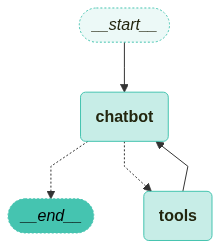

In [15]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

In [16]:
from langchain_teddynote.messages import display_message_tree

question = "테디노트 YouTube"

for event in graph.stream({"messages": [("user", question)]}):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        display_message_tree(value["messages"][-1])

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}